In [1]:
using Gadfly, DataFrames

In [2]:
function imitate(nodes::Int, prob::Float64, moved::Int)
    tot = 0
    for i in 1:(nodes - moved)
        for j in 1:moved
            if prob > rand() 
                tot = tot + 1 
                break
            end 
        end
    end
    tot
end

imitate (generic function with 1 method)

Suppose we have $n$ nodes and $m$ moved. We wish to determine how many nodes will imitate at least one of the $m$ nodes and move themselves. Each node will imitate with probability $p$. The number of nodes available to imitate is $k = n - m$. We can think of each of these $k$ nodes as having $m$ chances to imitate a node that moved:

\begin{equation*}
  X \sim\binom{m}{x}p^x(1-p)^{m-x}
\end{equation*}

A node moves if it imitated at least one of the other nodes:

\begin{equation*}
  P(X \geq 1) = 1 - P(X < 1) = 1 - (1-p)^m = z
\end{equation*}

where $z$ is the probability a node moves. The distribution representing the probability that $v$ nodes move is given by:

\begin{equation*}
    V \sim \binom{k}{v}z^v(1-z)^{k-v}
\end{equation*}

Thus we can determine the expected number of nodes that will move:

\begin{equation}
  \langle V \rangle = k - k(1 - p)^m
  \label{eq:expv}
\end{equation}


In [3]:
function expectedMoves(n::Int, p::Float64, m::Int)
    k = n - m
    k - k * (1 - p)^m
end

expectedMoves (generic function with 1 method)

In [4]:
function expectedMovesSim(n::Int, p::Float64, m::Int, trials::Int)
    im = 0
    for i in 1:trials
        im = im + imitate(n, p, m)
    end
    im / trials
end

expectedMovesSim (generic function with 1 method)

In [5]:
n = 10
p = .5
m = 5
expectedMoves(n, p, m)

4.84375

In [6]:
expectedMovesSim(n, p, m, 10^6)

4.843928

In [7]:
function catalyze(nodes::Int, prob::Float64, moved::Int, limit::Int = 10^4; force = true)
    record = [1]
    itr = 1
    while moved > 0 && itr < limit
        moved = imitate(nodes, prob, moved)
        push!(record, moved)
        if force && moved == 0
            moved = 1
        end
        itr = itr + 1
    end
    record
end

catalyze (generic function with 2 methods)

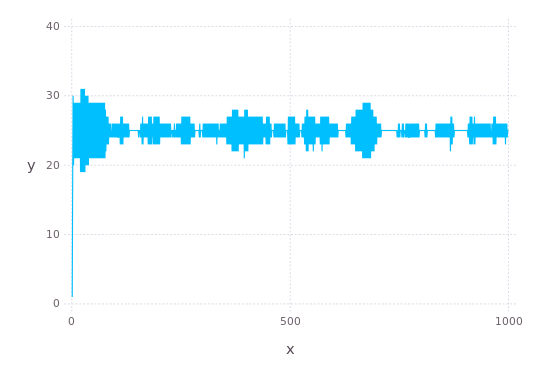

In [8]:
record = catalyze(50, .2, 3, 10^3, force = false);
mean(record);
plot(x = [x for x = 1:length(record)], y = record, Geom.line)

In [9]:
function simulate(folds::Int, totalnodes::Int, numprobs::Int, probstop::Float64)
    analysisnodes::Int = totalnodes - 1
    allmoves = Array{Float64}(analysisnodes, numprobs)
    alltime = Array{Float64}(analysisnodes, numprobs)
    probs = linspace(.01, probstop, numprobs)
    a = 1
    for p in probs, i in 2:totalnodes
        avgmoves = 0
        avgtime = 0
        for j in 1:folds
            record = catalyze(i, p, 1)
            avgmoves = avgmoves + (mean(record))
            avgtime = avgtime + length(record)
        end
        allmoves[a] = avgmoves / folds
        alltime[a] = avgtime / folds
        #print("|$i, $p: $(allmoves[a])")
        a = a + 1
    end
    (allmoves, alltime)
end

simulate (generic function with 1 method)

In [10]:
folds = 10
nodes = 30 
probs = 10
probstop = .99
probvalues = linspace(.01, probstop, probs)
(moves, time) = simulate(folds, nodes, probs, probstop);

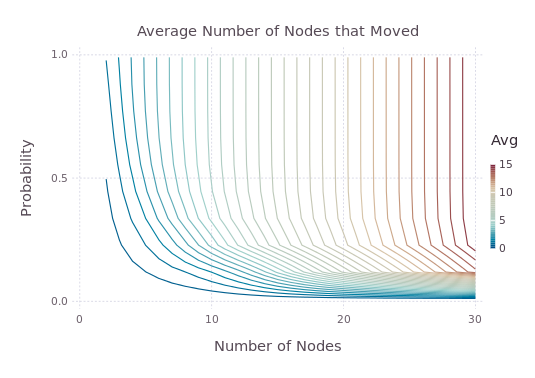

In [11]:
plot(z = moves, x = [x for x = 2:nodes], y = [x for x in probvalues],
Geom.contour(levels=30), Guide.xlabel("Number of Nodes"), Guide.ylabel("Probability"),
Guide.title("Average Number of Nodes that Moved"), Guide.colorkey("Avg"))

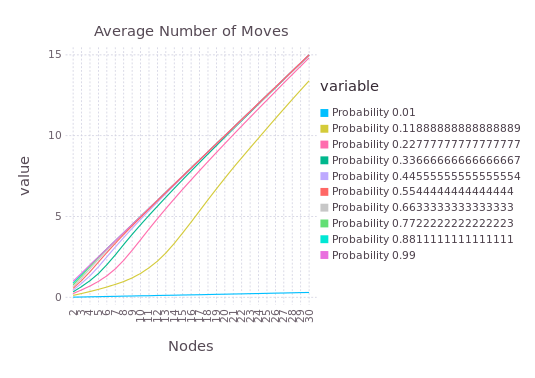

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:38
 in anonymous at no file
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/cfusting/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/cfusting/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[12], in expression starting on line 2


In [12]:
data = DataFrame([2:nodes moves])
names!(data, convert(Array{Symbol, 1}, ["Nodes", [symbol("Probability $x") for x in probvalues]]))
dat = stack(data, [2:probs + 1]);
plot(dat, x = "Nodes", y = "value", color = "variable", Geom.line,
Guide.title("Average Number of Moves"), Stat.xticks(ticks = [x for x = 2:nodes]))

Consider a network with weights $w \in A = [0,1)$ representing the probability of imitation.

In [5]:
using LightGraphs, TikzGraphs, StatsBase

In [6]:
function randomweights(n, p, divider) 
    W = zeros(n, n)
    for i in 1:n
        W[i,i] = 0
        for j in i+1:n
            if p > rand()
                r = rand() / divider
                W[i,j] = r
                W[j,i] = r
            end
        end
    end
    W
end

randomweights (generic function with 1 method)

In [26]:
function tenth(W, i, j; strengthen = true)
    if strengthen
        p = W[i,j] + 1/10 * (1 - W[i,j])
    else
        p = W[i,j] - 1/10 * W[i,j]
    end
    #print("New distance $dist\n")
    W[i,j] = p
    W[j,i] = p
end

tenth (generic function with 1 method)

In [8]:
function imitate(W, nodes, metric)
    snodes = sort(nodes)
    n = size(W, 1)
    imitated = Int[]
    ctr = 1
    for i in snodes
        #print("Scanning $i\n")
        for j in 1:n
            if !(j in snodes[1:ctr])
                if W[i,j] > rand()
                    print("$j imitated $i\n")
                    push!(imitated, j)
                    metric(W, i, j) 
                else
                    metric(W, i, j; strengthen = false)
                end
            end
        end
        ctr = ctr + 1
    end
    imitated
end

imitate (generic function with 1 method)

In [30]:
n = 6
p = 1/2
divider = 1
W = randomweights(n, p, divider)
W

6x6 Array{Float64,2}:
 0.0       0.366246  0.55971   0.0       0.717888  0.845821
 0.366246  0.0       0.392258  0.0       0.0       0.270764
 0.55971   0.392258  0.0       0.0       0.0       0.108847
 0.0       0.0       0.0       0.0       0.450622  0.949392
 0.717888  0.0       0.0       0.450622  0.0       0.851769
 0.845821  0.270764  0.108847  0.949392  0.851769  0.0     

In [31]:
nodes = sample(collect(1:n), 2, replace = false)

2-element Array{Int64,1}:
 2
 3

In [32]:
ctr = 1
while length(nodes) > 0 && ctr < 10
    nodes = imitate(W, nodes, tenth)
    ctr = ctr + 1
end
triu(W)
W

3 imitated 2
1 imitated 3


6x6 Array{Float64,2}:
 0.0       0.004864   0.820358  0.0       0.998955  0.999903 
 0.004864  0.0        0.275733  0.0       0.0       0.0704946
 0.820358  0.275733   0.0       0.0       0.0       0.441622 
 0.0       0.0        0.0       0.0       0.142151  0.999167 
 0.998955  0.0        0.0       0.142151  0.0       0.723671 
 0.999903  0.0704946  0.441622  0.999167  0.723671  0.0      

6 imitated 3
3 imitated 1
5 imitated 1
6 imitated 1
5 imitated 6
1 imitated 3
2 imitated 3
1 imitated 5
1 imitated 5
6 imitated 5
1 imitated 6
2 imitated 6
4 imitated 6
2 imitated 1
3 imitated 1
5 imitated 1
6 imitated 1
3 imitated 1
5 imitated 1
6 imitated 1
5 imitated 1
6 imitated 1
3 imitated 1
5 imitated 1
6 imitated 1
6 imitated 4
1 imitated 3
1 imitated 5
6 imitated 5
4 imitated 5
6 imitated 5
1 imitated 5
6 imitated 5
1 imitated 5
6 imitated 5
1 imitated 6
4 imitated 6
1 imitated 6
4 imitated 6
1 imitated 6
4 imitated 6
1 imitated 6
4 imitated 6
1 imitated 6
4 imitated 6
3 imitated 1
5 imitated 1
6 imitated 1
3 imitated 1
5 imitated 1
6 imitated 1
3 imitated 1
5 imitated 1
6 imitated 1
5 imitated 1
6 imitated 1
2 imitated 1
5 imitated 1
6 imitated 1
3 imitated 1
5 imitated 1
6 imitated 1
2 imitated 1
3 imitated 1
5 imitated 1
6 imitated 1
3 imitated 1
5 imitated 1
6 imitated 1
3 imitated 1
5 imitated 1
6 imitated 1
5 imitated 4
6 imitated 4
6 imitated 4
6 imitated 4
5 imitated 4

In [19]:
ctr - 1

0